# Ghana Crop Disease Detection (Dino model w/ MMDet library)

 - If `INSTALL_DEPENDENCIES = True` then all required dependencies will be installed in the notebook.
   - If `AUTO_RESTART_KERNEL = True` then the notebook kernel will be restarted after the dependencies have been installed. All cells    starting from the `Imports and set seed` section must be run after the kernel restart.
   - If `AUTO_RESTART_KERNEL = False` then please manually restart the kernel after installing dependencies

In [1]:
INSTALL_DEPENDENCIES = True
AUTO_RESTART_KERNEL = False

IMAGE_DIR = "/kaggle/input/ghana-crop-disease"
DATA_DIR  = "/kaggle/input/ghana-crop-dzs-annos"

DO_TRAIN = True
TRAIN_ON_ALL_DATA = True

DO_INFERENCE = True
INFERENCE_CHECKPOINT = None

## Install MMDetection and other dependencies

In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version`
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
if INSTALL_DEPENDENCIES:
    # %pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121
    %pip install torch==2.1.1 torchvision==0.16.1 --index-url https://download.pytorch.org/whl/cu121

    %pip install -U openmim
    !mim install mmengine
    !mim install "mmcv>=2.0.0rc4, <2.2.0"
    %pip install -q mmpretrain

    # !rm -rf mmdetection
    import os
    if not os.path.exists("./mmdetection"):
        !git clone https://github.com/open-mmlab/mmdetection.git
    %cd mmdetection
    %pip install -e .

    # %pip install -q -U torchmetrics pycocotools

    if AUTO_RESTART_KERNEL:
        import os; os._exit(00)

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 490.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0
    Uninstalling torch-2.4.0:
      Successfully uninstalled torch-2.4.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.0
    Uninstalling torchvision-0.19.0:
      Successfully uninstalled torchvision-0.19.0
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setu

In [4]:
import os
import glob
from pathlib import Path
import yaml
from PIL import Image
from functools import partial
import random
from copy import deepcopy
from rich.pretty import pprint
import pandas as pd
import torch
import mmdet
from mmdet.apis import DetInferencer
from mmdet.models.utils import weighted_boxes_fusion
import mmcv
from mmengine.fileio import dump, load
from mmengine.utils import track_iter_progress, get_git_hash
from mmengine.fileio import dump, load
from mmengine.utils.dl_utils import collect_env as collect_base_env
# from torchmetrics.detection import MeanAveragePrecision
from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info


if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

sys.platform: linux
Python: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
CUDA available: True
MUSA available: False
numpy_random_seed: 2147483648
GPU 0,1: Tesla T4
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 12.3, V12.3.107
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.1.1+cu121
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_8

In [6]:
def set_seed(s, reproducible=False):
    """
    This function is from the fastai library. Set random seed for `random`, `torch`,
    and `numpy` (where available)
    """
    try:
        torch.manual_seed(s)
    except NameError:
        pass
    try:
        torch.cuda.manual_seed_all(s)
    except NameError:
        pass
    try:
        np.random.seed(s%(2**32-1))
    except NameError:
        pass
    try:
        random.seed(s)
    except NameError:
        pass
    if reproducible:
        try:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        except NameError:
            pass

set_seed(277, reproducible=True)

## Perform Inference with An MMDet detector


In [7]:
%cd mmdetection

[Errno 2] No such file or directory: 'mmdetection'
/kaggle/working/mmdetection


In [8]:
# We download the pre-trained checkpoints for inference and finetuning.
!mim download mmdet --config dino-4scale_r50_improved_8xb2-12e_coco --dest ./checkpoints

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
processing dino-4scale_r50_improved_8xb2-12e_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MiB 14.9 MB/s eta 0:00:00
Successfully downloaded dino-4scale_r50_improved_8xb2-12e_coco_20230818_162607-6f47a913.pth to /kaggle/working/mmdetection/checkpoints
Successfully dumped dino-4scale_r50_improved_8xb2-12e_coco.py to /kaggle/working/mmdetection/checkpoints


### Inference the detector

This is a useful check to see that the pre-trained model is working as expected.

In [9]:
# Choose to use a config
model_name = 'dino-4scale_r50_improved_8xb2-12e_coco'

# Setup a checkpoint file to load
checkpoint = './checkpoints/dino-4scale_r50_improved_8xb2-12e_coco_20230818_162607-6f47a913.pth'

# Set the device to be used for evaluation
device = 'cuda:0'

# Initialize the DetInferencer
inferencer = DetInferencer(model_name, checkpoint, device)

Loads checkpoint by local backend from path: ./checkpoints/dino-4scale_r50_improved_8xb2-12e_coco_20230818_162607-6f47a913.pth
12/16 15:42:53 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [10]:
# Use the detector to do inference
img = './demo/demo.jpg'
result = inferencer(img, out_dir='./output')

Output()

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming 
release, it will be required to pass the indexing argument. (Triggered internally at 
../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

In [11]:
# Show the structure of result dict
pprint(result, max_length=4)

{
│   'predictions': [
│   │   {
│   │   │   'labels': [2, 13, 2, 2, ... +296],
│   │   │   'scores': [0.8803523182868958, 0.8536122441291809, 0.8370338678359985, 0.8010976314544678, ... +296],
│   │   │   'bboxes': [
│   │   │   │   [295.24749755859375, 115.88931274414062, 379.6995544433594, 149.975341796875],
│   │   │   │   [222.05184936523438, 176.24693298339844, 455.96258544921875, 382.8081970214844],
│   │   │   │   [190.6014862060547, 108.81534576416016, 298.07476806640625, 155.72869873046875],
│   │   │   │   [481.2956848144531, 110.62369537353516, 522.8267211914062, 129.9768829345703],
│   │   │   │   ... +296
│   │   │   ]
│   │   }
│   ],
│   'visualization': [
│   │   array([[[ 28,  48,  13],
│   │   [ 37,  63,  28],
│   │   [ 30,  64,  27],
│   │   ...,
│   │   [ 23,  47,  31],
│   │   [ 31,  67,  31],
│   │   [ 54,  92,  17]],
│      
│      [[ 23,  42,   0],
│   │   [ 25,  50,   8],
│   │   [ 30,  62,  21],
│   │   ...,
│   │   [ 92, 114, 102],
│   │   [ 16,  53,  12],
│   │   [ 44,  75,  16]],
│      
│      [[ 20,  50,   0],
│   │   [ 25,  59,   8],
│   │   [ 29,  66,  23],
│   │   ...,
│   │   [ 47,  70,  44],
│   │   [ 29,  60,  18],
│   │   [ 54,  77,  31]],
│      
│      ...,
│      
│      [[ 63,  68,  45],
│   │   [ 58,  66,  27],
│   │   [ 74,  84,  49],
│   │   ...,
│   │   [ 32,  46,  23],
│   │   [ 56,  76,  39],
│   │   [ 31,  47,  18]],
│      
│      [[ 60,  66,  40],
│   │   [ 45,  55,  18],
│   │   [ 83,  92,  61],
│   │   ...,
│   │   [ 63,  77,  54],
│   │   [ 47,  67,  30],
│   │   [ 35,  52,  20]],
│      
│      [[ 64,  70,  42],
│   │   [ 85,  95,  60],
│   │   [ 66,  75,  48],
│   │   ...,
│   │   [ 37,  51,  28],
│   │   [ 59,  79,  42],
│   │   [ 44,  61,  29]]], dtype=uint8)
│   ]
}

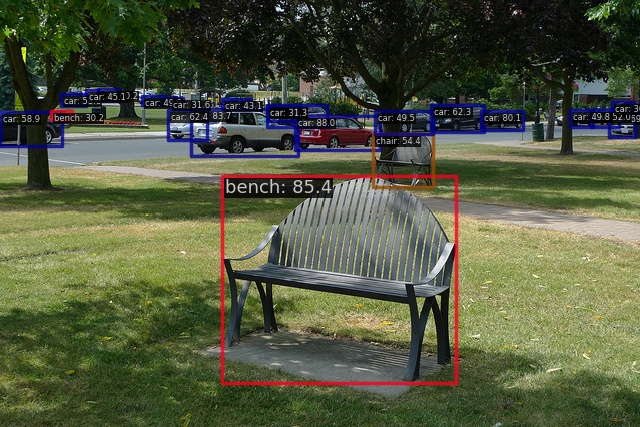

In [12]:
# Show the output image
Image.open('./output/vis/demo.jpg')

## Train with customized datasets

In this part, you will know how to train predefined models with customized datasets and then test it. We use the [balloon dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon) as an example to describe the whole process.

The basic steps are as below:

1. Prepare the customized dataset
2. Prepare a config
3. Train, test, and infer models on the customized dataset.

#### COCO annotation format
The necessary keys of COCO format for instance segmentation are as below, for the complete details, please refer [here](https://cocodataset.org/#format-data).

```json
{
    "images": [image],
    "annotations": [annotation],
    "categories": [category]
}
image = {
    "id": int,
    "width": int,
    "height": int,
    "file_name": str,
}
annotation = {
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height], # (x, y) are the coordinates of the upper left corner of the bbox
    "iscrowd": 0 or 1,
}
categories = [{
    "id": int,
    "name": str,
    "supercategory": str,
}]
```

In [13]:
def convert_df_to_coco(df_annot, out_file, image_dir):
    img_ids = df_annot["Image_ID"].drop_duplicates().tolist()
    annotations = []
    images = []
    obj_count = 0
    # for idx, v in enumerate(track_iter_progress([v_ for v_ in data_infos.values()])):
    for idx, img_id in enumerate(track_iter_progress(img_ids)):
        tmp = df_annot[df_annot["Image_ID"] == img_id].copy()
        img_path = os.path.join(image_dir, img_id)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(
            dict(id=idx, file_name=img_id, height=height, width=width))

        tmp["bb_w"] = tmp["xmax"] - tmp["xmin"]
        tmp["bb_h"] = tmp["ymax"] - tmp["ymin"]
        tmp["area"] = tmp["bb_w"] * tmp["bb_h"]
        bboxes = tmp[["xmin", "ymin", "bb_w", "bb_h"]].values.tolist()
        catids = tmp["class_id"].tolist()
        catstr = tmp["class"].tolist()
        areas  = tmp["area"].tolist()
        assert len(bboxes) == len(catids)
        assert len(bboxes) == len(catstr)
        assert len(bboxes) == len(areas)

        for i in range(len(bboxes)):
            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=catids[i],
                bbox=bboxes[i],
                area=areas[i],
                segmentation=[],
                iscrowd=0
            )
            annotations.append(data_anno)
            obj_count += 1

    cats = df_annot[["class_id", "class"]].drop_duplicates().sort_values(by="class_id")
    cats = [{"id": i, "name": n} for i, n in zip(cats["class_id"], cats["class"])]
    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=cats
    )
    dump(coco_format_json, out_file)

In [14]:
img_dir = Path(IMAGE_DIR)
df = pd.read_csv(Path(DATA_DIR)/"Train.csv")

all_imgs = df["Image_ID"].drop_duplicates().tolist()
val_imgs = [img for img in all_imgs if random.random() < 0.2]
trn_imgs = set(all_imgs) - set(val_imgs)
assert len(all_imgs) == len(trn_imgs) + len(val_imgs)

vocab = sorted(list(set(df["class"])))
idx2cls = dict(enumerate(vocab))
cls2idx = {v: k for k, v in idx2cls.items()}

df["class_id"] = df["class"].apply(lambda c: cls2idx[c])

if TRAIN_ON_ALL_DATA:
    trn_imgs = all_imgs
    val_imgs = val_imgs[:20]
    df_trn = df.copy()
    # create 'dummy' validation set
    df_val = df[df["Image_ID"].isin(val_imgs)].copy()
    df_val["class_id"] = [i%len(vocab) for i in range(len(df_val))]
    df_val["class"] = df_val["class_id"].map(idx2cls)
    df_val["confidence"] = df_val["confidence"].fillna(1.)
    df_val[["xmin", "ymin"]] = df_val[["xmin", "ymin"]].fillna(0.)
    df_val[["xmax", "ymax"]] = df_val[["xmax", "ymax"]].fillna(10.)
    print(len(df_trn), len(df_val), len(trn_imgs), len(val_imgs))
else:
    df_trn = df[df["Image_ID"].isin(trn_imgs)].copy()
    df_val = df[df["Image_ID"].isin(val_imgs)].copy()
    print(len(df_trn), len(df_val), len(trn_imgs), len(val_imgs))
    assert len(df_trn) + len(df_val) == len(df)

41029 118 4902 20


In [15]:
convert_df_to_coco(df_annot=df_trn,
                   out_file='data/ghana_crop_dzs/train.json',
                   image_dir=img_dir)

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4902/4902, 11.0 task/s, elapsed: 447s, ETA:     0s


In [16]:
convert_df_to_coco(df_annot=df_val,
                   out_file='data/ghana_crop_dzs/val.json',
                   image_dir=img_dir)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 20/20, 15.9 task/s, elapsed: 1s, ETA:     0s


In [17]:
df_tst = pd.read_csv(Path(DATA_DIR)/"Test.csv")
df_tst["class_id"] = [i%len(vocab) for i in range(len(df_tst))]
df_tst["class"] = df_tst["class_id"].map(idx2cls)
df_tst["confidence"] = df_tst["confidence"].fillna(1.)
df_tst[["xmin", "ymin"]] = df_tst[["xmin", "ymin"]].fillna(0.)
df_tst[["xmax", "ymax"]] = df_tst[["xmax", "ymax"]].fillna(10.)
print(df_tst.shape)
df_tst.head()

(2101, 8)


,Image_ID,confidence,class,ymin,xmin,ymax,xmax,class_id
0,id_128pxx.jpg,1.0,Corn_Cercospora_Leaf_Spot,0.0,0.0,10.0,10.0,0
1,id_12jbci.jpg,1.0,Corn_Common_Rust,0.0,0.0,10.0,10.0,1
2,id_143s4o.jpg,1.0,Corn_Healthy,0.0,0.0,10.0,10.0,2
3,id_14tfmb.jpg,1.0,Corn_Northern_Leaf_Blight,0.0,0.0,10.0,10.0,3
4,id_14tw4o.jpg,1.0,Corn_Streak,0.0,0.0,10.0,10.0,4


In [18]:
convert_df_to_coco(df_annot=df_tst,
                   out_file='data/ghana_crop_dzs/test.json',
                   image_dir=img_dir)

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 2101/2101, 11.3 task/s, elapsed: 185s, ETA:     0s


## Prepare a config

### config convnext

In [19]:
from mmdet.registry import MODELS

# Unregister TIMMBackbone if it exists
if 'TIMMBackbone' in MODELS.module_dict:
    del MODELS.module_dict['TIMMBackbone']

In [20]:
from mmdet.registry import MODELS
import timm
import torch.nn as nn


@MODELS.register_module()
class TIMMBackbone(nn.Module):
    """Wrapper for using TIMM models as backbones in MMDetection."""

    def __init__(self, model_name, pretrained=True, out_indices=(0, 1, 2, 3), **kwargs):
        super(TIMMBackbone, self).__init__()
        valid_kwargs = {
            "drop_rate", "drop_path_rate", "global_pool", "checkpoint_path", "features_only"
        }
        timm_kwargs = {k: v for k, v in kwargs.items() if k in valid_kwargs}
        self.model = timm.create_model(
            model_name, pretrained=pretrained, features_only=True, out_indices=out_indices, **timm_kwargs
        )
        self.out_indices = out_indices
        self.out_channels = self.model.feature_info.channels()

    def forward(self, x):
        """Forward function."""
        return self.model(x)

In [21]:
model_code = '''
from mmdet.registry import MODELS
import timm
import torch.nn as nn


@MODELS.register_module()
class TIMMBackbone(nn.Module):
    """Wrapper for using TIMM models as backbones in MMDetection."""

    def __init__(self, model_name, pretrained=True, out_indices=(0, 1, 2, 3), **kwargs):
        super(TIMMBackbone, self).__init__()
        valid_kwargs = {
            "drop_rate", "drop_path_rate", "global_pool", "checkpoint_path", "features_only"
        }
        timm_kwargs = {k: v for k, v in kwargs.items() if k in valid_kwargs}
        self.model = timm.create_model(
            model_name, pretrained=pretrained, features_only=True, out_indices=out_indices, **timm_kwargs
        )
        self.out_indices = out_indices
        self.out_channels = self.model.feature_info.channels()

    def forward(self, x):
        """Forward function."""
        return self.model(x)
'''
if not os.path.exists("projects/custom_backbones"):
    os.mkdir("projects/custom_backbones")
with open("projects/custom_backbones/timm_convnext_backbone.py", "w") as f:
    f.write(model_code)

In [22]:
# Usually run validation after each epoch, except when we're training on all training data.
# When training all all the data then validation is useless, so we set the `val_interval`
# in the config the same as `max_epochs`
_val_interval = 13 if TRAIN_ON_ALL_DATA else 1

In [23]:
config_file = f"""
# Inherit and overwrite part of the config based on this config
_base_ = './dino-4scale_r50_improved_8xb2-12e_coco.py'

import os

data_root = 'data/ghana_crop_dzs/' # dataset root

train_batch_size_per_gpu = 4
train_num_workers = 4

max_epochs = 13
base_lr = 0.0001
accum_steps = 2

metainfo = dict(
    classes=(
        'Corn_Cercospora_Leaf_Spot', 'Corn_Common_Rust', 'Corn_Healthy', 'Corn_Northern_Leaf_Blight',
        'Corn_Streak', 'Pepper_Bacterial_Spot', 'Pepper_Cercospora', 'Pepper_Early_Blight',
        'Pepper_Fusarium', 'Pepper_Healthy', 'Pepper_Late_Blight', 'Pepper_Leaf_Blight',
        'Pepper_Leaf_Curl', 'Pepper_Leaf_Mosaic', 'Pepper_Septoria', 'Tomato_Bacterial_Spot',
        'Tomato_Early_Blight', 'Tomato_Fusarium', 'Tomato_Healthy', 'Tomato_Late_Blight',
        'Tomato_Leaf_Curl', 'Tomato_Mosaic', 'Tomato_Septoria',
    ),
)

custom_imports = dict(
    imports=['projects.custom_backbones.timm_convnext_backbone'],  # Path to your custom TIMM backbone
    allow_failed_imports=False
)

checkpoint_file = None

model = dict(
    backbone=dict(
        type='TIMMBackbone',
        model_name='convnext_tiny',   # Replace with your desired TIMM model
        pretrained=True,              # Use the pretrained weights
        out_indices=[1, 2, 3],        # Specify which feature layers to use
        checkpoint_path=checkpoint_file,
    ),
    neck=dict(in_channels=[192, 384, 768]),  # convnext (t and s)
    bbox_head=dict(num_classes=23))

test_pipeline = [
    dict(type='LoadImageFromFile', backend_args={{{{_base_.backend_args}}}}),
    dict(type='Resize', scale=(800, 800), keep_ratio=False),
    # If you don't have a gt annotation, delete the pipeline
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='PackDetInputs',
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape',
                   'scale_factor'))
]

train_pipeline = [
    dict(type='LoadImageFromFile', backend_args={{{{_base_.backend_args}}}}),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RandomFlip', prob=0.5),
    dict(
        type='RandomChoice',
        transforms=[
            [
                dict(type='Resize', scale=(800, 800), keep_ratio=False),
                dict(type='YOLOXHSVRandomAug'),
                dict(type='RandomFlip', prob=0.5),
            ],
            [
                dict(
                    type='RandomChoiceResize',
                    # The radio of all image in train dataset < 7
                    # follow the original implement
                    scales=[(400, 4200), (500, 4200), (600, 4200)],
                    keep_ratio=True),
                dict(
                    type='RandomCrop',
                    crop_type='absolute_range',
                    crop_size=(384, 600),
                    allow_negative_crop=True),
                dict(type='Resize', scale=(800, 800), keep_ratio=False),
                dict(type='YOLOXHSVRandomAug'),
                dict(type='RandomFlip', prob=0.5),
            ]
        ]),
    dict(type='PackDetInputs')
]

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img=os.path.abspath("{IMAGE_DIR}")),
        ann_file='train.json',
        filter_cfg=dict(filter_empty_gt=False),
        pipeline=train_pipeline))

val_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img=os.path.abspath("{IMAGE_DIR}")),
        ann_file='val.json',
        pipeline=test_pipeline))

test_dataloader = val_dataloader
val_evaluator = dict(ann_file=data_root + 'val.json')
test_evaluator = val_evaluator

# Optimizer Hook for Mixed Precision
optimizer_config = dict(
    type='Fp16OptimizerHook',
    loss_scale='dynamic',
    accumulation_steps=accum_steps
)
# Mixed-Precision Training
fp16 = dict()

default_hooks = dict(
    checkpoint=dict(
        interval=0,
        max_keep_ckpts=2,  # only keep latest 2 checkpoints
        save_best='auto'
    ),
    logger=dict(type='LoggerHook', interval=50))

# load COCO pre-trained weight
load_from = './checkpoints/dino-4scale_r50_improved_8xb2-12e_coco_20230818_162607-6f47a913.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval={_val_interval})

optim_wrapper = dict(
    optimizer=dict(lr=base_lr),
    paramwise_cfg=dict(
        custom_keys=dict(
            backbone=dict(lr_mult=0.1),
            sampling_offsets=dict(lr_mult=0.1),
            reference_points=dict(lr_mult=0.1)
        )
    )
)

param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=1000),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=7,
        end=max_epochs,
        T_max=7,
        by_epoch=True,
        convert_to_iter_based=True),
]

auto_scale_lr = dict(enable=False)
"""

with open('./configs/dino/dino_r50_ghana_crop_dzs.py', 'w') as f:
    f.write(config_file)

## Train

In [24]:
!python tools/train.py configs/dino/dino_r50_ghana_crop_dzs.py --amp --cfg-options randomness.seed=673748432

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
12/16 15:53:49 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 673748432
    GPU 0,1: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.3, V12.3.107
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.

## Validation

In [25]:
if not TRAIN_ON_ALL_DATA:
    !python tools/test.py configs/dino/dino_r50_ghana_crop_dzs.py \
        work_dirs/dino_r50_ghana_crop_dzs/epoch_13.pth \
        --out work_dirs/dino_r50_ghana_crop_dzs/pred_dino_val.pkl \
        --tta

## Inference

In [26]:
test_config_file = """
# Inherit and overwrite part of the config based on this config
_base_ = './dino_r50_ghana_crop_dzs.py'

data_root = 'data/ghana_crop_dzs/' # dataset root

test_dataloader = dict(
    dataset=dict(
        ann_file='test.json'))

test_evaluator = dict(ann_file=data_root+'test.json')

tta_model = dict(
    type='DetTTAModel',
    tta_cfg=dict(
        nms=dict(type='nms', iou_threshold=0.5), max_per_img=300))
"""

with open('./configs/dino/dino_r50_ghana_crop_dzs_test.py', 'w') as f:
    f.write(test_config_file)

In [27]:
if DO_INFERENCE:
    checkpoint = "work_dirs/dino_r50_ghana_crop_dzs/epoch_13.pth" if INFERENCE_CHECKPOINT is None else INFERENCE_CHECKPOINT
    
    !python tools/test.py configs/dino/dino_r50_ghana_crop_dzs_test.py \
        {checkpoint} \
        --out work_dirs/dino_r50_ghana_crop_dzs_test/pred_dino_tst.pkl \
        --tta

/opt/conda/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/kaggle/working/mmdetection/tools/test.py:103: UserWarning: Cannot find ``tta_pipeline`` in config, we will set it as default.
  warnings.warn('Cannot find ``tta_pipeline`` in config, '
12/16 22:30:28 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
    CUDA available: True
    MUSA available: False
    n

In [28]:
if DO_INFERENCE:
    preds = load("work_dirs/dino_r50_ghana_crop_dzs_test/pred_dino_tst.pkl")

    tst_vocab = ["NEG"] + vocab
    df_pred_box = []
    for i in range(len(preds)):
        pred = preds[i]["pred_instances"]
        if len(pred["bboxes"]) > 0:
            tmp = pd.DataFrame(pred["bboxes"].numpy(), columns=["xmin", "ymin", "xmax", "ymax"])
            tmp["confidence"] = pred["scores"].numpy()
            tmp["class_idx"] = pred["labels"].numpy() + 1
        else:
            tmp = pd.DataFrame([[0, 0, 0, 0]], columns=["xmin", "ymin", "xmax", "ymax"])
            tmp["confidence"] = 1
            tmp["class_idx"] = 0
        tmp["Image_ID"] = list(df_tst["Image_ID"])[i]
        df_pred_box.append(tmp)
    
    df_pred_box = pd.concat(df_pred_box, ignore_index=True)
    df_pred_box["class"] = df_pred_box["class_idx"].apply(lambda idx: tst_vocab[idx])
    df_pred_box = df_pred_box[["Image_ID", "class", "confidence", "ymin", "xmin", "ymax", "xmax"]]
    df_pred_box = df_pred_box.drop_duplicates().reset_index(drop=True)
    _ = df_pred_box.to_csv("../submission_dino_convnext_t.csv", index=False)